# TF Hub

https://tfhub.dev/

In [1]:
import os
import math
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import tensorflow_hub as hub

model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
                   trainable=True),  # Can be True, see below.
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.build([None, 256, 256, 3])  # Batch input shape.

adam = keras.optimizers.Adam(lr=0.0001)
model.compile(
    optimizer=adam,
    loss='binary_crossentropy',
    metrics='accuracy'
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              5919312   
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 5,920,593
Trainable params: 5,859,985
Non-trainable params: 60,608
_________________________________________________________________


In [3]:
import albumentations as A
import cv2

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            # Declare an augmentation pipeline
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15,
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2),
            ])
    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            return img

In [4]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size,
                 fold, mode='train', shuffle=True):
        self.fold = fold
        self.shuffle = shuffle
        self.mode = mode
        self.batch_size = batch_size
        self.image_size = image_size
        
        self.df = pd.read_csv(csv_path)
        if self.mode == 'train':    
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### Remove invalid files
        #### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()
            
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
    
        for _, r in data.iterrows():
            file_name = r['file_name']

            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                image = image.astype('uint8')
                image = self.transform(image=image)
                
            image = image.astype('float32')
            image = image / 255.

            label = int(r['species']) - 1

            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
csv_path = 'data/kfolds.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=64,
    image_size=256,
    shuffle=True)

valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=64,
    image_size=256,
    shuffle=True)

In [13]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10
92/92 [==============================] - 65s 705ms/step - loss: 0.2387 - accuracy: 0.9123 - val_loss: 0.0279 - val_accuracy: 0.9925
Epoch 2/10
92/92 [==============================] - 63s 684ms/step - loss: 0.0337 - accuracy: 0.9908 - val_loss: 0.0167 - val_accuracy: 0.9946
Epoch 3/10
92/92 [==============================] - 64s 696ms/step - loss: 0.0216 - accuracy: 0.9949 - val_loss: 0.0096 - val_accuracy: 0.9973
Epoch 4/10
92/92 [==============================] - 63s 686ms/step - loss: 0.0110 - accuracy: 0.9961 - val_loss: 0.0088 - val_accuracy: 0.9973
Epoch 5/10
92/92 [==============================] - 61s 660ms/step - loss: 0.0120 - accuracy: 0.9971 - val_loss: 0.0102 - val_accuracy: 0.9966
Epoch 6/10
92/92 [==============================] - 62s 671ms/step - loss: 0.0119 - accuracy: 0.9964 - val_loss: 0.0062 - val_accuracy: 0.9980
Epoch 7/10
92/92 [==============================] - 62s 673ms/step - loss: 0.0077 - accuracy: 0.9980 - val_loss: 0.0072 - val_accuracy: 0.9973

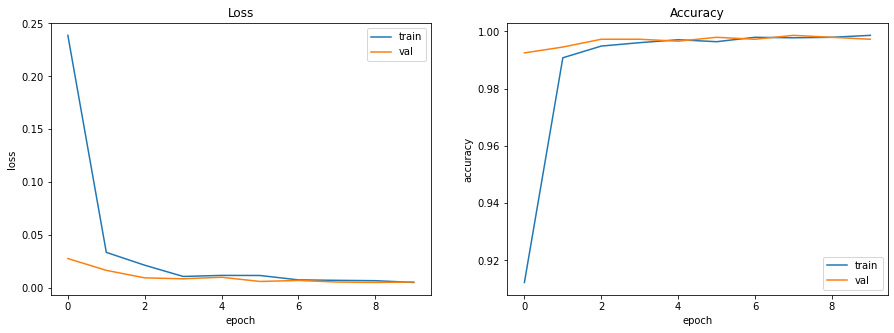

In [14]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()